In [1]:
%matplotlib widget

import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import auxFuncs as aux
import HbXConcentrations as hbx

In [2]:
# Load sample MC simulations

imagesMC1, shapeImagesMC1 = aux.loadMatStruct("MC2Inc660_2.mat", "flux")
imagesMC2, shapeImagesMC2 = aux.loadMatStruct("MC2Inc830_2.mat", "flux")

imagesMC1CW, shapeImagesMC1CW = aux.loadMatStruct("Tomo_DosInc_reg_660posOrig_pared_a2cm.mat", "flux")
imagesMC2CW, shapeImagesMC2CW = aux.loadMatStruct("Tomo_DosInc_reg_830posOrig_pared_a2cm.mat", "flux")

In [28]:
sigmaGauss = 12
fftStrength = 0
cropSizeX = 70
cropSizeY = 70
maxDev = 5
doTotMap = False
colorMap = "Spectral_r"

# Without chest wall

In [4]:
# Perfom smoothing

for i in range(shapeImagesMC1[0]):
    imagesMC1[i] = aux.fftGauss(imagesMC1[i], fftStrength)[0]
    
for i in range(shapeImagesMC2[0]):
    imagesMC2[i] = aux.fftGauss(imagesMC2[i], fftStrength)[0]

In [5]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1[0],2))
centersPos2 = np.empty((shapeImagesMC2[0],2))

for i in range(shapeImagesMC1[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1[i], smooth=0)
    
for i in range(shapeImagesMC2[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2[i], smooth=0)

In [6]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

for i, image in enumerate(imagesMC1):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

In [7]:
# Generate background normalization image

back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)
#plt.imshow(back1)
#plt.show()

In [8]:
# Compute normalized crops

imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2
#plt.imshow(imagesDiv1[12])
#plt.show()

In [9]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=sigmaGauss,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights)
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights)


36it [00:00, 65.49it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/auxFuncs.py:233: RuntimeWarning: invalid value encountered in divide
  imageRecon = imageReconTemp/imageReconCount
36it [00:00, 64.03it/s]


In [10]:
minValPos = 15

extent = [minValPos , 250, 250, minValPos]

recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
#plt.imshow(recon2DCrop1, extent=extent)
#plt.colorbar()

In [11]:
recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]
#plt.imshow(recon2DCrop2, extent=extent)
#plt.colorbar()

In [12]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D = HbXMaps_2D[:,:,1]
OxyMap_2D = HbXMaps_2D[:,:,0]
TotMap_2D = desOxyMap_2D + OxyMap_2D

Step 1/2...


100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


Step 2/2...


100%|██████████| 36/36 [00:14<00:00,  2.42it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:162: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [13]:
import scipy as sc

desOxyMap_2D_filtered = sc.ndimage.median_filter(desOxyMap_2D,4)
OxyMap_2D_filtered = sc.ndimage.median_filter(OxyMap_2D,4)

#desOxyMap_2D_filtered = desOxyMap_2D
#OxyMap_2D_filtered = OxyMap_2D

desOxyMap_2D_filtered[desOxyMap_2D_filtered==np.nan] = 0
OxyMap_2D_filtered[OxyMap_2D_filtered==np.nan] = 0

np.savetxt("MC2Incs_HbRMap.dat", desOxyMap_2D_filtered)
np.savetxt("MC2Incs_HbOMap.dat", OxyMap_2D_filtered)

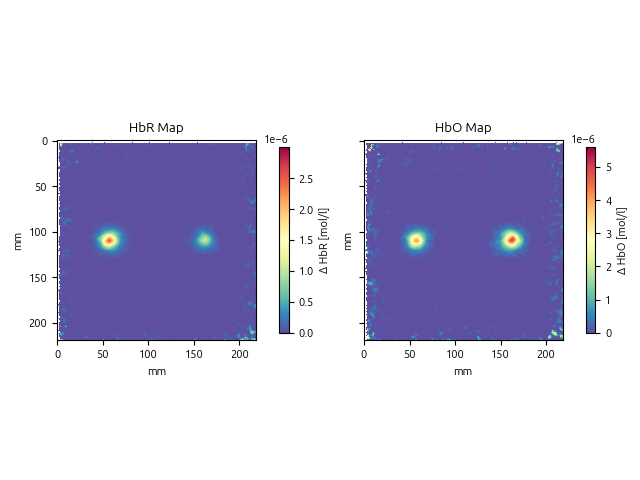

In [40]:
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)

if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_2D_filtered)
median = np.nanmedian(desOxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")
DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")

sd = np.nanstd(OxyMap_2D_filtered)
median = np.nanmedian(OxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_2D = desOxyMap_2D_filtered + OxyMap_2D_filtered

        sd = np.nanstd(TotMap_2D)
        median = np.nanmedian(TotMap_2D)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        
        Tot.set_title("Total HB HBMap")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()

plt.show()
figSats.savefig("MC2Incs_HbXMaps_noTot.png", bbox_inches='tight', dpi=300)

# With Chest Wall (2cm Depth)

In [15]:
# Perfom smoothing

for i in range(shapeImagesMC1[0]):
    imagesMC1CW[i] = aux.fftGauss(imagesMC1CW[i], fftStrength)[0]
    
for i in range(shapeImagesMC2[0]):
    imagesMC2CW[i] = aux.fftGauss(imagesMC2CW[i], fftStrength)[0]

In [16]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1CW[0],2))
centersPos2 = np.empty((shapeImagesMC2CW[0],2))

for i in range(shapeImagesMC1CW[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1CW[i], smooth=0)
    
for i in range(shapeImagesMC2CW[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2CW[i], smooth=0)

In [17]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

for i, image in enumerate(imagesMC1CW):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2CW):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

In [18]:
# Generate background normalization image

back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)
#plt.imshow(back1)

In [19]:
# Compute normalized crops

imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2
#plt.imshow(imagesDiv1[12])

In [20]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=sigmaGauss,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights)
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights)


36it [00:00, 66.54it/s]
36it [00:00, 67.00it/s]


In [21]:
minValPos = 15

extent = [minValPos , 250, 250, minValPos]

recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
plt.imshow(recon2DCrop1, extent=extent)
plt.colorbar()

In [22]:
recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]
#plt.imshow(recon2DCrop2, extent=extent)
#plt.colorbar()

In [23]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D_CW = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D_CW = HbXMaps_2D_CW[:,:,1]
OxyMap_2D_CW = HbXMaps_2D_CW[:,:,0]
TotMap_2D_CW = desOxyMap_2D_CW + OxyMap_2D_CW

Step 1/2...


100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


Step 2/2...


100%|██████████| 36/36 [00:14<00:00,  2.44it/s]


In [24]:
import scipy as sc

desOxyMap_2D_filtered_CW = sc.ndimage.median_filter(desOxyMap_2D_CW,4)
OxyMap_2D_filtered_CW = sc.ndimage.median_filter(OxyMap_2D_CW,4)

#desOxyMap_2D_filtered = desOxyMap_2D
#OxyMap_2D_filtered = OxyMap_2D

desOxyMap_2D_filtered_CW[desOxyMap_2D_filtered_CW==np.nan] = 0
OxyMap_2D_filtered_CW[OxyMap_2D_filtered_CW==np.nan] = 0

np.savetxt("MC2Incs_CW_HbRMapW.dat", desOxyMap_2D_filtered_CW)
np.savetxt("MC2Incs_CW_HbOMap.dat", OxyMap_2D_filtered_CW)

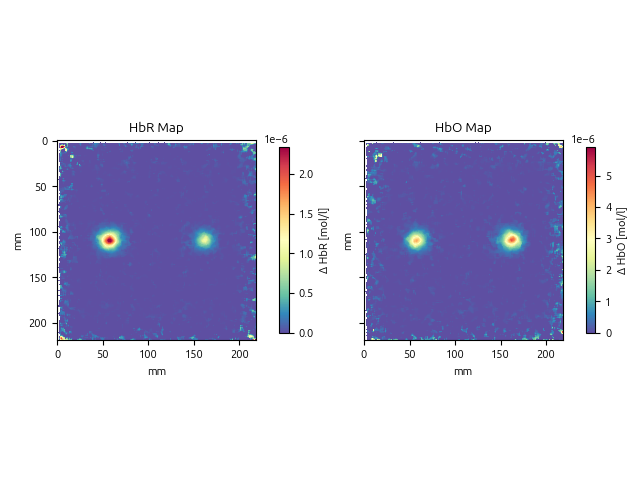

In [41]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)


if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_2D_filtered_CW)
median = np.nanmedian(desOxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered_CW, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")
DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")

sd = np.nanstd(OxyMap_2D_filtered_CW)
median = np.nanmedian(OxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered_CW, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_2D = desOxyMap_2D_filtered_CW + OxyMap_2D_filtered_CW

        sd = np.nanstd(TotMap_2D_CW)
        median = np.nanmedian(TotMap_2D_CW)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D_CW, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        
        Tot.set_title("Total HB HBMap")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()
plt.show()

figSats.savefig("MC2Incs_HbXMaps_noTot_ChestWall.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_164267/3113578491.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 2, figsize=(


(219, 219)


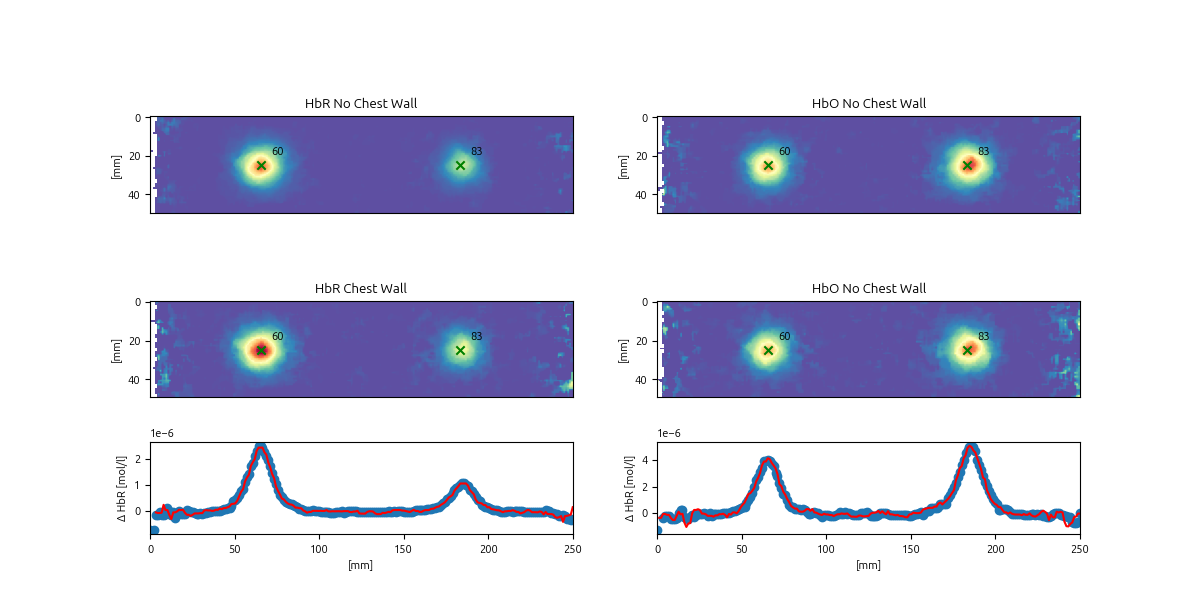

In [49]:
minValPos = 15
vertSize = 25

offsetX = 0

midVertPoint = int(np.shape(desOxyMap_2D_filtered)[0]/2)

extent = [minValPos, 250, vertSize*2, 0]
extent = None
fig, axs = plt.subplots(3, 2, figsize=(
    12, 6), gridspec_kw={'height_ratios': [2, 2, 1]})
plt.subplots_adjust(hspace=0.)  # Adjust the vertical spacing between subplots

sd = np.nanstd(desOxyMap_2D_filtered)
median = np.nanmedian(desOxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0
axs[0, 0].imshow(desOxyMap_2D_filtered[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)

for i in range(len(interestPositions)):
    axs[0, 0].scatter(interestPositions[i][1]+offsetX,
                   vertSize, marker="x", c="green")
    axs[0, 0].annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]+offsetX,
                    vertSize), xytext=(10,10), textcoords="offset pixels" )
    
axs[0, 0].set_title("HbR No Chest Wall")
axs[0, 0].set_ylabel("[mm]")
axs[0, 0].get_xaxis().set_visible(False)

sd = np.nanstd(OxyMap_2D_filtered)
median = np.nanmedian(OxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0
axs[0, 1].imshow(OxyMap_2D_filtered[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
for i in range(len(interestPositions)):
    axs[0, 1].scatter(interestPositions[i][1]+offsetX,
                   vertSize, marker="x", c="green")
    axs[0, 1].annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]+offsetX,
                    vertSize), xytext=(10,10), textcoords="offset pixels" )

axs[0, 1].set_title("HbO No Chest Wall")
axs[0, 1].set_ylabel("[mm]")
axs[0, 1].get_xaxis().set_visible(False)

sd = np.nanstd(desOxyMap_2D_filtered_CW)
median = np.nanmedian(desOxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0
axs[1, 0].imshow(desOxyMap_2D_filtered_CW[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
for i in range(len(interestPositions)):
    axs[1, 0].scatter(interestPositions[i][1]+offsetX,
                   vertSize, marker="x", c="green")
    axs[1, 0].annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]+offsetX,
                    vertSize), xytext=(10,10), textcoords="offset pixels" )

axs[1, 0].set_title("HbR Chest Wall")
axs[1, 0].set_ylabel("[mm]")
axs[1, 0].get_xaxis().set_visible(False)

sd = np.nanstd(OxyMap_2D_filtered_CW)
median = np.nanmedian(OxyMap_2D_filtered_CW)
vmax = median + maxDev * sd
vmin = 0
axs[1, 1].imshow(OxyMap_2D_filtered_CW[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
for i in range(len(interestPositions)):
    axs[1, 1].scatter(interestPositions[i][1]+offsetX,
                   vertSize, marker="x", c="green")
    axs[1, 1].annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]+offsetX,
                    vertSize), xytext=(10,10), textcoords="offset pixels" )


axs[1, 1].set_title("HbO No Chest Wall")
axs[1, 1].set_ylabel("[mm]")
axs[1, 1].get_xaxis().set_visible(False)


print(np.shape(desOxyMap_2D_filtered))

""" prof_HbR_noCW = np.pad(desOxyMap_2D_filtered[midVertPoint, :], (int(
    (250-np.shape(desOxyMap_2D_filtered)[0])/2), int((250-np.shape(desOxyMap_2D_filtered)[0])/2)), mode="constant", constant_values=0)
prof_HbO_noCW = np.pad(OxyMap_2D_filtered[midVertPoint, :], (int(
    (250-np.shape(OxyMap_2D_filtered)[0])/2), int((250-np.shape(OxyMap_2D_filtered)[0])/2)), mode="constant", constant_values=0)
prof_HbR_CW = np.pad(desOxyMap_2D_filtered_CW[midVertPoint, :], (int(
    (250-np.shape(desOxyMap_2D_filtered_CW)[0])/2), int((250-np.shape(desOxyMap_2D_filtered_CW)[0])/2)), mode="constant", constant_values=0)
prof_HbO_CW = np.pad(OxyMap_2D_filtered_CW[midVertPoint, :], (int(
    (250-np.shape(OxyMap_2D_filtered_CW)[0])/2), int((250-np.shape(OxyMap_2D_filtered_CW)[0])/2)), mode="constant", constant_values=0) """

""" prof_HbR_noCW = np.pad(desOxyMap_2D_filtered[midVertPoint, :], (20,0), mode="constant", constant_values=0)
prof_HbO_noCW = np.pad(OxyMap_2D_filtered[midVertPoint, :], (20,0), mode="constant", constant_values=0)
prof_HbR_CW = np.pad(desOxyMap_2D_filtered_CW[midVertPoint, :], (20,0), mode="constant", constant_values=0)
prof_HbO_CW = np.pad(OxyMap_2D_filtered_CW[midVertPoint, :], (20,0), mode="constant", constant_values=0) """

prof_HbR_noCW = desOxyMap_2D_filtered[midVertPoint, :]
prof_HbO_noCW = OxyMap_2D_filtered[midVertPoint, :]
prof_HbR_CW = desOxyMap_2D_filtered_CW[midVertPoint, :]
prof_HbO_CW = OxyMap_2D_filtered_CW[midVertPoint, :]

x_scale = np.linspace(0,250,np.shape(desOxyMap_2D_filtered)[0])

axs[2, 0].scatter(x_scale, prof_HbR_noCW)
axs[2, 0].plot(x_scale, prof_HbR_CW, c="red")
axs[2, 0].set_xlabel("[mm]")
axs[2, 0].set_ylabel("Δ HbR [mol/l]")
axs[2, 0].set_xlim(0,250)

axs[2, 1].scatter(x_scale, prof_HbO_noCW)
axs[2, 1].plot(x_scale, prof_HbO_CW, c="red")
axs[2, 1].set_xlabel("[mm]")
axs[2, 1].set_ylabel("Δ HbR [mol/l]")
axs[2, 1].set_xlim(0,250)
plt.show()